# 레버리지와 아웃라이어

# 레버리지

개별적인 데이터 표본 하나하나가 회귀분석 결과에 미치는 영향력은 레버리지 분석을 통해 알 수 있다.

**레버리지(leverage)** 는 실제 종속변수값 $y$가 예측치(predicted target) $\hat{y}$에 미치는 영향을 나타낸 값이다. self-influence, self-sensitivity 라고도 한다.

레버리지 값은 `RegressionResult` 클래스의 `get_influence` 메서드로 다음과 같이 구할 수 있다. 우선 다음과 같은 가상의 1차 데이터로 회귀분석 예제를 풀어보자

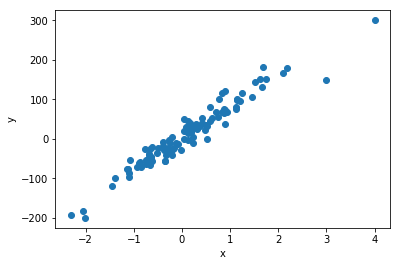

In [4]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_boston
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# 100개의 데이터 생성
X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20, 
                              coef=True, random_state=1)

# 레버리지가 높은 가상의 데이터를 추가
data_100 = (4, 300)
data_101 = (3, 150)
X0 = np.vstack([X0, np.array([data_100[:1], data_101[:1]])])
X = sm.add_constant(X0)
y = np.hstack([y, [data_100[1], data_101[1]]])

plt.scatter(X0, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [6]:
model = sm.OLS(pd.DataFrame(y), pd.DataFrame(X))
result = model.fit()
print(result.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.935   
Dependent Variable: 0.0000           AIC:                909.4298
Date:               2018-07-01 23:15 BIC:                914.6797
No. Observations:   102              Log-Likelihood:     -452.71 
Df Model:           1                F-statistic:        1464.   
Df Residuals:       100              Prob (F-statistic): 1.61e-61
R-squared:          0.936            Scale:              427.81  
--------------------------------------------------------------------
       Coef.     Std.Err.       t       P>|t|      [0.025     0.975]
--------------------------------------------------------------------
0      3.2565      2.0647     1.5772    0.1179    -0.8398     7.3528
1     78.3379      2.0475    38.2597    0.0000    74.2756    82.4001
-----------------------------------------------------------------
Omnibus:              16.191       Durbin-Watson:          1.885 
Prob(Omnibus

선형회귀 결과에서 `get_influence` 메서드를 호출하면 영향도 정도 객체를 구할 수 있다. 이 객체는 `hat_matrix_diag` 속성으로 레버리지 벡터를 가지고 있다.

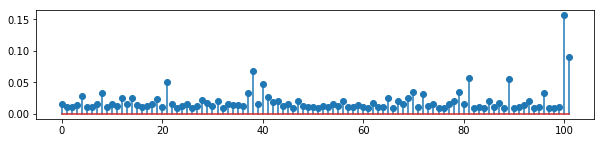

In [10]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

수동으로 추가한 두 개의 데이터를 제외하면 대부분의 데이터는 레버리지 값이 0.02 근처의 낮은 값을 가진다. 레버리지의 합이 2와 같아진다는 것도 다음과 같이 확인할 수 있다.

In [11]:
hat.sum()

2.0000000000000004

위 결과를 이용하여 레버리지가 큰 데이터만 표시하면 아래와 같다. 여기에서는 레버리지 값이 0.05를 넘는 데이터만 큰 원으로 표시하였다.

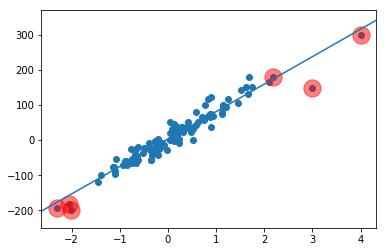

In [12]:
ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, ax=ax)

idx = hat > 0.05
plt.scatter(X0[idx], y[idx], s=300, c="r", alpha=0.5)
plt.show()

위 그림에서 데이터가 무리지어 있지 않고 단독으로 존재할수록 레버리지가 커짐을 알 수 있다.

# 레버리지의 영향

레버리지가 큰 데이터가 모형에 주는 영향을 보기 위해 이 데이터가 포함된 경우의 모형과 포함되지 않은 경우의 모형을 아래에 비교하였다. 레버리지가 큰 데이터는 포함되거나 포함되지 않는가에 따라 모형에 주는 영향이 큰 것을 알 수 있다.

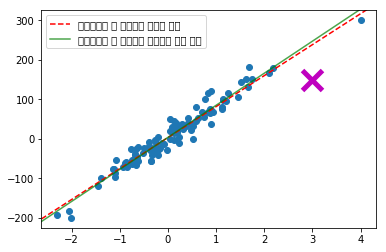

In [13]:
model2 = sm.OLS(y[:-1], X[:-1])
result2 = model2.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result,
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result2,
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-1], y[-1], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 큰 데이터를 포함한 경우", u"레버리지가 큰 데이터를 포함하지 않은 경우"],
           loc="upper left")
plt.show()

반대로 레버리지가 작은 데이터는 포함되거나 포함되지 않거나 모형이 별로 달라지지 않는 것을 알 수 있다.

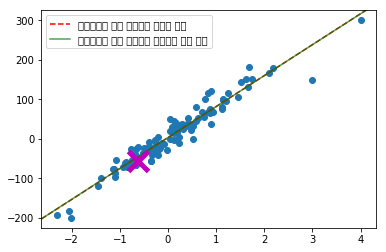

In [14]:
model3 = sm.OLS(y[1:], X[1:])
result3 = model3.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, 
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result3, 
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[0], y[0], marker='x', c="m", ms=20, mew=5)
plt.legend([u"레버리지가 작은 데이터를 포함한 경우", u"레버리지가 작은 데이터를 포함하지 않은 경우"], 
           loc="upper left")
plt.show()

혹은 레버리지가 크더라도 오차가 작은 데이터는 포함되거나 포함되지 않거나 모형이 별로 달라지지 않는다.

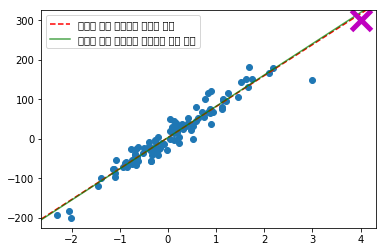

In [15]:
idx = np.array(list(range(100)) + [101])
model4 = sm.OLS(y[idx], X[idx, :])
result4 = model4.fit()

ax = plt.subplot()
plt.scatter(X0, y)
sm.graphics.abline_plot(model_results=result, 
                        c="r", linestyle="--", ax=ax)
sm.graphics.abline_plot(model_results=result4, 
                        c="g", alpha=0.7, ax=ax)

plt.plot(X0[-2], y[-2], marker='x', c="m", ms=20, mew=5)
plt.legend([u"오차가 작은 데이터를 포함한 경우", u"오차가 작은 데이터를 포함하지 않은 경우"], 
           loc="upper left")
plt.show()

# 아웃라이어

모형에서 설명하고 있는 데이터와 동떨어진 값을 가지는 데이터, 즉 잔차가 큰 데이터를 **아웃라이어(outlier)** 라고 한다. 그런데 잔차의 크기는 독립 변수의 영향을 받으므로 아웃라이어를 찾으려면 이 영향을 제거한 표준화된 잔차를 계산해야한다.

# StatsModels를 이용한 표준화 잔차 계산

아래에서는 각 데이터의 잔차를 표시하였다. 잔차는 `RegressionResult` 객체의 `resid` 속성에 있다.

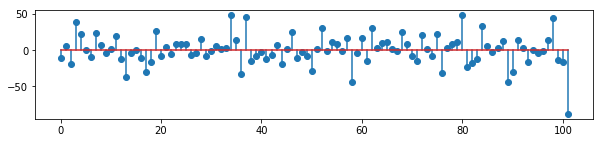

In [16]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid)
plt.show()

표준화 잔차는 `resid_pearson` 속성에 있다. 보통 표준화 잔차가 2~4보다 크면 아웃라이어로 본다.

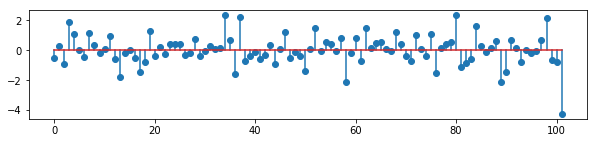

In [17]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid_pearson)
plt.show()